# Run All

In [31]:
from ipywidgets import interact, IntSlider
import os
import nibabel as nib
import eval_seg
eval_seg.reload()

import numpy as np

root = 'datasets/alg_out/'
root_original_img = 'datasets/origdata'
root_out = 'results'
import importlib


import json

items = []
for dataset in ['Task001_LiverTumor', 'Task002_Pancreas', 'Task003_Multiorgan']:
    for file in sorted(os.listdir(f'{root}/{dataset}/GroundTruth')):
        items.append((dataset, file, 'z'))


def compute(inp):
    # print(inp)
    return _compute(*inp)


def _compute(dataset, file, axes):
    gt_nib = nib.load(f'{root}/{dataset}/GroundTruth/{file}')
    gt_orig = gt_nib.dataobj[...]
    voxelsize_orig = np.array(nib.affines.voxel_sizes(gt_nib.affine))
    import traceback
    import warnings
    import sys
    
#     def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

#         log = file if hasattr(file,'write') else sys.stderr
#         traceback.print_stack(file=log)
#         log.write(warnings.formatwarning(message, category, filename, lineno, line))

#     warnings.showwarning = warn_with_traceback
    original_img_path = f'{root_original_img}/{dataset}/{file}'.replace('.nii.gz', '_0000.nii.gz')
    ct_orig = nib.load(original_img_path).dataobj[...] if os.path.isfile(original_img_path) else None
    ct_orig = gt_orig if ct_orig is None else ct_orig
    gtmax = (gt_orig.sum(axis=2).sum(axis=1).argmax(), gt_orig.sum(axis=2).sum(axis=0).argmax(), gt_orig.sum(axis=1).sum(axis=0).argmax())

    outdir1 = f'{root_out}/{dataset}/{file}/'
    os.makedirs(outdir1, exist_ok=True)

    data_orig = {
        typ: nib.load(f'{root}/{dataset}/{typ}/{file}').dataobj[...] for typ in ['GroundTruth', 'CE', 'Dice', 'DiceCE', 'DiceFocal', 'DiceTopK10', 'TopK10']
    }

    eval_seg.ui.ortho_slicer(ct_orig, data_orig, gtmax, args={'show': 0, 'dst': f'{outdir1}/ortho_slice'})
    all_axes = {'x': 0, 'y': 1, 'z': 2, 'all': -1}

    
    classes=int(max(gt_orig.max(),max([data_orig[typ].max() for typ in data_orig]))+1)
    # print('number of classes:',classes)
    res={}
    
    for ax in all_axes:
        if not (ax in axes):
            continue
        axi = all_axes[ax]
        try:
            outdir2 = f'{outdir1}/{ax}/' + (f'{gtmax[axi]}' if ax != 'all' else '')
            os.makedirs(outdir2, exist_ok=True)
            
            if ax == 'all':
                gt, voxelsize = gt_orig, voxelsize_orig
            else:
                gt, voxelsize = eval_seg.geometry.slice(gt_orig, voxelsize_orig, axi, [gtmax[axi]])
                ct,_ = eval_seg.geometry.slice(ct_orig, voxelsize, axi, [gtmax[axi]])
                data = {p: eval_seg.geometry.slice(data_orig[p], voxelsize, axi, [gtmax[axi]])[0] for p in data_orig}
                eval_seg.ui.multi_plot_2d(
                    ct,
                    data,
                    args={
                        "imglabel": f"{dataset.split('_')[1]} {file.split('_')[1].split('.')[0]} {ax}={gtmax[axi]}",
                        'z_titles':[gtmax[axi]],
                        "add_backimg": 1,
                        "clahe": 1,
                        "crop2roi": 1,
                        "zoom2segments": 1,
                        "add_notzoom_img": 1,
                        #                 'interactive':1,
                        "show_tp_fp_fn": 1,
                        "show": 0,
                        "dst": f"{outdir2}/allmethods",
                        "spacing": voxelsize,
                    },
                )
            
            mme = eval_seg.metrics.MME(classes, debug={'show_precompute': 1})
            mme.set_reference(gt, spacing=voxelsize)
            
            for typ in data:

                pr = data[typ]
                outdir3 = f'{outdir2}/{typ}/'
                os.makedirs(outdir3, exist_ok=True)
                # pr=pr_orig if ax == 'all' else plotui.slice(pr_orig,axi,[gtmax[axi]])
                # global ev
                ev = mme.evaluate(pr)
                with open(f'{outdir3}/metric.json', 'w') as f:
                    # print(ev)
                    json.dump(ev, f, indent=4, cls=eval_seg.common.NumpyEncoder)
                res[typ]=ev 

        except Exception as e:
            print(dataset, file, axes)
            print({d: data_orig[d].sum() for d in data_orig})
            raise e
    return res


# compute(items[2])
# for i in range(10):
#     print(i)
#     compute(items[i])
# _compute('Task001_LiverTumor', 'train_114.nii.gz', ['z'])

In [32]:
# for k,v in eval_seg.common.parallel_runner(compute,items,parallel=1):
#     print(k,v)

res={k:v for k,v in eval_seg.common.parallel_runner(compute,items,parallel=1)}

all_mme={}
for k,v in res.items():
    v=res[v]

  0%|          | 0/178 [00:00<?, ?it/s]

TypeError: unhashable type: 'dict'

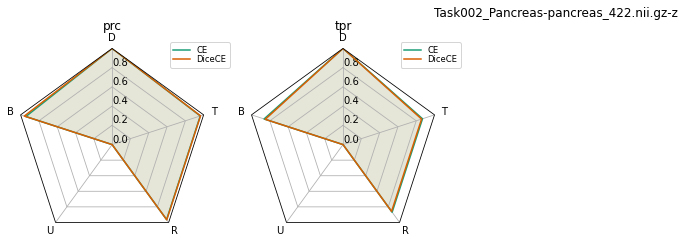

array([<RadarAxesSubplot:title={'center':'prc'}>,
       <RadarAxesSubplot:title={'center':'tpr'}>, <RadarAxesSubplot:>,
       <RadarAxesSubplot:>, <RadarAxesSubplot:>], dtype=object)

In [101]:
eval_seg.reload()
all_mme={}
# dataset,file,ax=('Task001_LiverTumor', 'train_19.nii.gz', 'z')
dataset,file,ax=('Task002_Pancreas', 'pancreas_422.nii.gz', 'z')
for typ in ['CE','DiceCE']:
    x=res[(dataset,file,ax)][typ]['class'][1]['total']
    df=eval_seg.metrics.traditional.calculate_prc_tpr_f1_multi(x)
    # print(df)
    all_mme[typ]=df[['prc','tpr']]
import pandas as pd




# eval_seg.ui.spider_chart_multi(all_mme,np.arange(0,1,.2),title=f'{dataset}-{file}-{ax}')
all_mme=pd.concat(all_mme).stack().unstack(0).swaplevel(0,1)
all_mme={c:all_mme.loc[c] for c in all_mme.index.get_level_values(0).unique()}

eval_seg.ui.spider_chart_multi(all_mme,np.arange(0,1,.2),title=f'{dataset}-{file}-{ax}')

In [96]:
all_mme

{'prc':          CE    DiceCE
 B  0.999995  0.999995
 D  0.999990  0.999990
 R  0.975795  0.999987
 T  0.975806  1.000000
 U  0.999990  0.999990,
 'tpr':          CE    DiceCE
 B  0.999995  0.999995
 D  0.499998  0.499998
 R  0.423075  0.388110
 T  0.454887  0.417293
 U  0.999990  0.999990}

In [ ]:
eval_seg.reload()
def test(i):
    return i
for p in eval_seg.common.parallel_runner(test,items),max_threads=2):
    print(p)

In [29]:
{items[1]:8}

{('Task001_LiverTumor', 'train_108.nii.gz', 'z'): 8}